In [1]:
import pandas as pd
import os
import numpy as np
from scipy.optimize import curve_fit
import scipy.stats as stats
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
####USER DEFINED VARIABLES####

#input dirs with csv files with cytometry data for all replicates
ctrl_variants_indir = '/Users/stephaniecrilly/Kortemme_lab/helix_sliding/20241118_remaining_hinge_titration_plotting/all_hinge_titration_files/ctrl_mutants'
new_variants_indir = '/Users/stephaniecrilly/Kortemme_lab/helix_sliding/20241118_remaining_hinge_titration_plotting/all_hinge_titration_files/new_variants'
indir = '/Users/stephaniecrilly/Kortemme_lab/helix_sliding/20241118_remaining_hinge_titration_plotting/all_hinge_titration_files'

#groups for plotting
ctrl_variants = ['wt', 'A114T', 'V111L', 'A73E', 'L66T']
new_variants = ['wt', 'V111F', 'V111I']

#plotting settings
plot_color_dict={'wt':'black', 'A114T':'#777777', 'L66T':'#1b7837', 'A73E':'#acd39e', 'V111L':'#dddddd', 'V111F':'#228833', 'V111I':'#009988'}
legend_label_dict = {'wt':'cs221', 'A114T':'A114T', 'V111L':'V111L', 'A73E':'A73E', 'L66T':'L66T', 'V111I':'V111I', 'V111F':'V111F'}

#output info
outdir = os.getcwd()
file_header = 'f2s_hinge_switch_tuning'

####

In [3]:
####FUNCTIONS####

def sigmoid(b_tot, Kd, p_tot, bg):
    '''
    Equation for a sigmoidal curve
    For curve fit with this function, 
    pass array of y vals as log10 transformed fluorescence
    paass array of x vals as -log10 transformed concentration of binder
    
    Parameters:
    b_tot: -log10 transformed binder concentration values (Molar)
    Kd: dissociation constant
    p_tot: total protein concentration (upper asymptote)
    bg: background signal (lower aymptote)

    '''
    return np.log(p_tot * (10**b_tot/((10**b_tot)+(10**Kd))) + bg) #equivalent to A.M.Phillips sigmoid function

####

/opt/anaconda3/envs/plotting/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/plotting/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/plotting/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='Log10 fold change Kd \n(normalized to WT)', ylabel='Variant'>

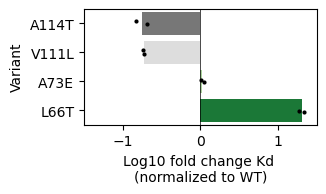

In [4]:
####PLOT CONTROL KDS NORMALIZED TO WT####

ctrl_file_list = os.listdir(ctrl_variants_indir)

ctrl_variant_list = []
all_ctrl_kd_list = []
all_ctrl_norm_kd_list = []

dfs_to_plot = []

for file in ctrl_file_list:
    if file.endswith('.csv'):
        df = pd.read_csv(ctrl_variants_indir + '/' + file)
        df[['Hinge', 'Variant', 'Induction', 'cs221B [nM]']] = df['Sample ID:'].str.split('_', expand=True)
        dfs_to_plot.append(df)

        variants = df['Variant'].unique()

        kd_list = []
        norm_kd_list = []

        for variant in variants:
            if variant in ctrl_variants:
                subset_df = df.query("Induction == 'SG' & Hinge == 'cs221' & Variant == @variant", engine='python').copy()

                x_vals = np.array(subset_df['cs221B [nM]'])
                x_vals = -np.log10(x_vals.astype(float)*1e-9)

                y_vals = np.array(subset_df['APC-positive Median FITC-A'])
                y_vals = y_vals.astype(float)
                y_vals = np.log10(y_vals)

                popt, pcov = curve_fit(sigmoid, -x_vals,
                                    y_vals,
                                    p0=[(-10), 10**(5), 10**(3)],
                                    bounds=[(-12,
                                                100,
                                                1),
                                            (-7,
                                                1000000,
                                                100000)],
                                    maxfev=400000)
            
                if round(10**(popt[0])*1e9, 2) == 100000:
                    kd_val = '> 50000'
                else:
                    kd_val = round(10**(popt[0])*1e9, 3)
            
                ctrl_variant_list.append(variant)
                kd_list.append(kd_val)
        
        all_ctrl_kd_list = all_ctrl_kd_list + kd_list

        norm_kd_list = [x/kd_list[0] for x in kd_list]
        all_ctrl_norm_kd_list = all_ctrl_norm_kd_list + norm_kd_list


ctrl_kds_df = pd.DataFrame(list(zip(ctrl_variant_list, all_ctrl_kd_list)), columns=['Variant', 'Kd (nM)'])
ctrl_norm_kds_df = pd.DataFrame(list(zip(ctrl_variant_list, all_ctrl_norm_kd_list)), columns=['Variant', 'Kd (nM)'])
ctrl_norm_kds_df['log_norm_kd'] = np.log10(ctrl_norm_kds_df['Kd (nM)'])

#get average log10 norm kd for barplot
variant_groups_df = ctrl_norm_kds_df.groupby(['Variant'])['Kd (nM)'].mean().reset_index(name='mean_norm_kd')
variant_groups_df['log_mean_norm_kd'] = np.log10(variant_groups_df['mean_norm_kd'])

#modify df for plotting
variants_not_to_plot = ['wt']
variant_groups_df = variant_groups_df.sort_values(by='log_mean_norm_kd', ascending=True)
variant_groups_df = variant_groups_df.query("Variant not in @variants_not_to_plot", engine='python').copy()

# Create a figure and axes
plt.rcParams["font.size"] = 10
fig, ax = plt.subplots()
fig.set_size_inches(3, 1.5)

# Create diverging bars
ax.barh(variant_groups_df['Variant'], np.maximum(variant_groups_df['log_mean_norm_kd'], 0), color=[plot_color_dict['A73E'], plot_color_dict['L66T']])
ax.barh(variant_groups_df['Variant'], np.minimum(variant_groups_df['log_mean_norm_kd'], 0), color=[plot_color_dict['A114T'], plot_color_dict['V111L']])

# Add a vertical line at zero
ax.axvline(0, color='black', linewidth=0.5)

# Set axes and labels
ax.set_xlim([-1.5, 1.5])
ax.set_xlabel('Log10 fold change Kd \n(normalized to WT)')

#plot replicate data points
sns.stripplot(data=ctrl_norm_kds_df.query("Variant not in @variants_not_to_plot", engine='python'), x='log_norm_kd', y='Variant', s=3, color='black')

# Show the plot
#plt.savefig(outdir + '/' + file_header + '_ctrl_kds_normalized_to_wt.png', dpi=300, pad_inches=0.1, bbox_inches = 'tight')

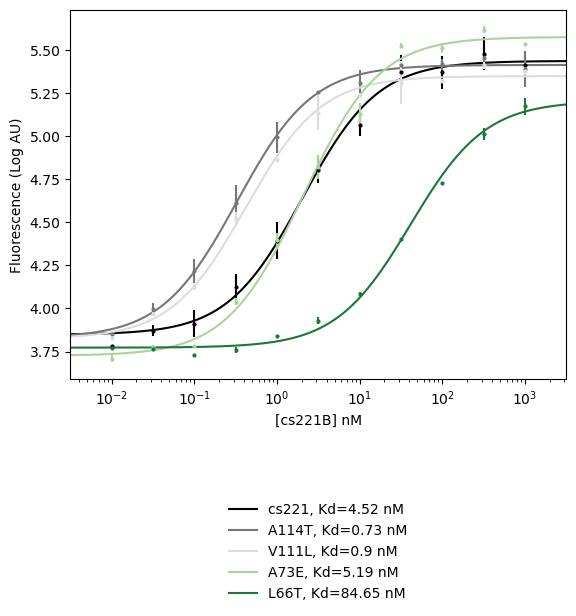

In [5]:
####PLOT CONTROL BINDING CURVES####
###OG HINGE MUTANTS ONLY####

file_list = os.listdir(ctrl_variants_indir)
x_vals_dict = {}
y_vals_dict = {}
popt_dict = {}

#fit sigmoidal curve to each individual replicate

for variant in ctrl_variants:
    
    x_vals_list = []
    y_vals_list = []
    popt_array = np.empty((0,3), int)

    for file in file_list:
        if file.endswith('.csv'):
            df = pd.read_csv(ctrl_variants_indir + '/' + file)
            df[['Hinge', 'Variant', 'Induction', 'cs221B [nM]']] = df['Sample ID:'].str.split('_', expand=True)

            if variant not in df['Variant'].unique():
                continue

            else:
                subset_df = df.query("Induction == 'SG' & Hinge == 'cs221' & Variant == @variant", engine='python').copy()

                x_vals = np.array(subset_df['cs221B [nM]'])
                x_vals = -np.log10(x_vals.astype(float))
                
                #take care of case where I have one less concentration
                if len(x_vals) == 10:
                    x_vals_list.append(np.append(x_vals, np.nan))
                else:
                    x_vals_list.append(x_vals)

                y_vals = np.array(subset_df['APC-positive Median FITC-A'])
                y_vals = y_vals.astype(float)
                y_vals = np.log10(y_vals)
                
                #take care of case where I have one less concentration
                if len(y_vals) == 10:
                    y_vals_list.append(np.append(y_vals, np.nan))
                else:
                    y_vals_list.append(y_vals)

                popt, pcov = curve_fit(sigmoid, -x_vals,
                                    y_vals,
                                    p0=[(1), 10**(5), 10**(3)],
                                    bounds=[(-1,
                                                100,
                                                1),
                                            (2,
                                                1000000,
                                                100000)],
                                    maxfev=400000)
                
                popt_array = np.concatenate((popt_array, popt.reshape(1,-1)))

    popt_dict[variant] = popt_array

    x_vals_dict[variant] = np.vstack(x_vals_list)
    y_vals_dict[variant] = np.vstack(y_vals_list)


#plot curve that using the mean popt of all replicates
#plot mean data points with error bars

plotted_curve_range = np.linspace(-2.5, 3.5, 100000)

for variant in ctrl_variants:

    #plot mean curve
    variant_array = popt_dict[variant]
    avg_popt = np.mean(variant_array, axis=0)

    kd_val = round(10**(avg_popt[0]), 2)

    plt.plot((10**plotted_curve_range), sigmoid(plotted_curve_range, avg_popt[0], avg_popt[1], avg_popt[2]), ls='-', color=plot_color_dict[variant], label=f'{legend_label_dict[variant]}, Kd={kd_val} nM')

    #calculate mean and error for data points
    variant_x_val_array = x_vals_dict[variant]
    variant_y_val_array = y_vals_dict[variant]

    y_mean = np.nanmean(variant_y_val_array, axis=0)

    #uncomment below to plot standard deviation error bars
    error = stats.tstd(variant_y_val_array, axis=0)

    #uncomment below to plot 95% confidence interval error bars
    #error = stats.t.interval(0.95, len(y_mean)-1, loc=y_mean, scale=stats.sem(variant_y_val_array, axis=0))

    plt.errorbar((10**-variant_x_val_array[0,]), y_mean, yerr=error, fmt='o', color=plot_color_dict[variant], markersize=2)

    #uncomment below to plot mean point only
    #plt.scatter((10**-variant_x_val_array[0,]), y_mean, color=plot_color_dict[variant], s=5)

    #plot settings
    plt.rcParams["figure.figsize"] = [2,2]
    plt.xscale('log')
    plt.xlim(10**-2.5, 10**3.5)
    plt.xlabel('[cs221B] nM', fontsize=10)
    plt.ylabel('Fluorescence (Log AU)', fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.legend(loc='upper center', bbox_to_anchor=[0.5,-0.3], fontsize=10, frameon=False)

    #plt.savefig(outdir + '/' + file_header + '_ctrl_binding_curves.png', dpi=300, pad_inches=0.1, bbox_inches = 'tight')

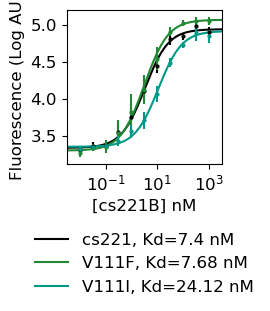

In [6]:
####PLOT NEW VARIANT BINDING CURVES####
##NEW V111 ONLY####

file_list = os.listdir(new_variants_indir)
x_vals_dict = {}
y_vals_dict = {}
popt_dict = {}

#fit sigmoidal curve to each individual replicate

for variant in new_variants:
    
    x_vals_list = []
    y_vals_list = []
    popt_array = np.empty((0,3), int)

    for file in file_list:
        if file.endswith('.csv'):
            df = pd.read_csv(new_variants_indir + '/' + file)
            df[['Hinge', 'Variant', 'Induction', 'cs221B [nM]']] = df['Sample ID:'].str.split('_', expand=True)

            if variant not in df['Variant'].unique():
                continue

            else:
                subset_df = df.query("Induction == 'SG' & Hinge == 'cs221' & Variant == @variant", engine='python').copy()

                x_vals = np.array(subset_df['cs221B [nM]'])
                x_vals = -np.log10(x_vals.astype(float))
                
                #take care of case where I have one less concentration
                if len(x_vals) == 10:
                    x_vals_list.append(np.append(x_vals, np.nan))
                else:
                    x_vals_list.append(x_vals)

                y_vals = np.array(subset_df['APC-positive Median FITC-A'])
                y_vals = y_vals.astype(float)
                y_vals = np.log10(y_vals)
                
                #take care of case where I have one less concentration
                if len(y_vals) == 10:
                    y_vals_list.append(np.append(y_vals, np.nan))
                else:
                    y_vals_list.append(y_vals)

                popt, pcov = curve_fit(sigmoid, -x_vals,
                                    y_vals,
                                    p0=[(1), 10**(5), 10**(3)],
                                    bounds=[(-1,
                                                100,
                                                1),
                                            (2,
                                                1000000,
                                                100000)],
                                    maxfev=400000)
                
                popt_array = np.concatenate((popt_array, popt.reshape(1,-1)))

    popt_dict[variant] = popt_array

    x_vals_dict[variant] = np.vstack(x_vals_list)
    y_vals_dict[variant] = np.vstack(y_vals_list)


#plot curve that using the mean popt of all replicates
#plot mean data points with error bars

plotted_curve_range = np.linspace(-2.5, 3.5, 100000)

for variant in new_variants:

    #plot mean curve
    variant_array = popt_dict[variant]
    avg_popt = np.mean(variant_array, axis=0)

    kd_val = round(10**(avg_popt[0]), 2)

    plt.plot((10**plotted_curve_range), sigmoid(plotted_curve_range, avg_popt[0], avg_popt[1], avg_popt[2]), ls='-', color=plot_color_dict[variant], label=f'{legend_label_dict[variant]}, Kd={kd_val} nM')

    #calculate mean and error for data points
    variant_x_val_array = x_vals_dict[variant]
    variant_y_val_array = y_vals_dict[variant]

    y_mean = np.nanmean(variant_y_val_array, axis=0)

    #uncomment below to plot standard deviation error bars
    error = stats.tstd(variant_y_val_array, axis=0)

    #uncomment below to plot 95% confidence interval error bars
    #error = stats.t.interval(0.95, len(y_mean)-1, loc=y_mean, scale=stats.sem(variant_y_val_array, axis=0))

    plt.errorbar((10**-variant_x_val_array[0,]), y_mean, yerr=error, fmt='o', color=plot_color_dict[variant], markersize=2)

    #uncomment below to plot mean point only
    #plt.scatter((10**-variant_x_val_array[0,]), y_mean, color=plot_color_dict[variant], s=5)

    #plot settings
    plt.xscale('log')
    plt.xlim(10**-2.5, 10**3.5)
    plt.xlabel('[cs221B] nM', fontsize=12)
    plt.ylabel('Fluorescence (Log AU)', fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(loc='upper center', bbox_to_anchor=[0.5,-0.35], fontsize=12, frameon=False)

    #plt.savefig(outdir + '/' + file_header + '_new_V111_binding_curves.png', dpi=300, pad_inches=0.1, bbox_inches = 'tight')
